In [1]:
from collections import defaultdict

from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from consent.consistency.util import get_scan_root_dir, get_scan_dirs, FIG_DIR
from ooutil.df_util import read_data_files
from ooutil.url_util import get_suffixed_domain

pd.options.display.max_rows = 100

location = 'uk'
SCAN_DIRS = get_scan_dirs(location)
SCAN_ROOT_DIR = get_scan_root_dir(location)
print(f"{SCAN_ROOT_DIR=}")
print(f"{SCAN_DIRS=}")

SCAN_ROOT_DIR=PosixPath('/mnt/sdd/ducbui/projects/data2/consent/2023-04-24')
SCAN_DIRS=[PosixPath('/mnt/sdd/ducbui/projects/data2/consent/2023-04-24/pref_menu_scan_0k_20k'), PosixPath('/mnt/sdd/ducbui/projects/data2/consent/2023-04-24/pref_menu_scan_20k_100k')]


In [2]:
cookie_prefs_files = list(SCAN_ROOT_DIR.glob('cookie_prefs_*.parquet'))
print(sorted(f.name for f in cookie_prefs_files))
cookie_prefs = read_data_files(cookie_prefs_files) # pd.read_parquet(cookie_prefs_file)
cookie_prefs.head()

['cookie_prefs_0k_20k.parquet', 'cookie_prefs_20k_100k.parquet']


100%|██████████| 2/2 [00:00<00:00,  2.94it/s]


,name,domain,duration,category_id,category,consent_mode,site,lib_name,pattern_name,consent
0,__cflb,secure.accor.com,1 days,C0001,Strictly Necessary Cookies,always active,ibis.com,onetrust,en.json,True
1,__RequestVerificationToken,group.accor.com,Session,C0001,Strictly Necessary Cookies,always active,ibis.com,onetrust,en.json,True
2,_dc_gtm_UA-xxxxxxxx,accor.com,0 days,C0001,Strictly Necessary Cookies,always active,ibis.com,onetrust,en.json,True
3,_Hw2h_,accor.com,Session,C0001,Strictly Necessary Cookies,always active,ibis.com,onetrust,en.json,True
4,_integrity_,all.accor.com,Session,C0001,Strictly Necessary Cookies,always active,ibis.com,onetrust,en.json,True


In [3]:
all_complies_files = list(SCAN_ROOT_DIR.glob('all_complies_*.parquet'))
print(sorted(f.name for f in all_complies_files))
all_complies = read_data_files(all_complies_files)
all_complies.head()

['all_complies_0k_20k.parquet', 'all_complies_20k_100k.parquet']


100%|██████████| 2/2 [00:00<00:00, 16.23it/s]


,name,domain,path,site,comply
0,OCC_all.accor,.accor.com,/,ibis.com,incorrect
1,visid_incap_2545443,.accor.com,/,ibis.com,omit
2,JSESSIONID,.accor.com,/,ibis.com,comply
3,dtSa,.accor.com,/,ibis.com,incorrect
4,trckCookie,.accor.com,/,ibis.com,incorrect


In [4]:
nsites = all_complies.site.nunique()
print(f'Number of sites with prefs: {cookie_prefs.site.nunique():,d}')
print(f"Number of sites with consistency: {nsites:,d}")
print(f'Number of flows analyzed: {len(all_complies):,d}')

Number of sites with prefs: 4,832
Number of sites with consistency: 4,795
Number of flows analyzed: 104,114


In [5]:
site_to_libname = {row['site']: row['lib_name'] for row in cookie_prefs[['site', 'lib_name']].drop_duplicates().to_dict('records')}
all_complies['lib_name'] = all_complies.site.map(site_to_libname)
all_complies_libs = all_complies.drop_duplicates(subset='site').lib_name.value_counts()
print(all_complies_libs.sum())
all_complies_libs

4795


onetrust     4250
cookiebot     514
termly         31
Name: lib_name, dtype: int64

In [6]:
# all_complies: comply flows, complies: comply cookies
complies = all_complies[['name', 'domain', 'path', 'site', 'comply']].drop_duplicates()
comply_counts = complies.comply.value_counts()
assert len(complies) == comply_counts.sum(), "Some cookie have 2 different comply values"
print(comply_counts.sum())
comply_counts

104114


omit         43878
incorrect    34981
comply       24882
ambiguous      373
Name: comply, dtype: int64

In [7]:
# Counts violated sites = at least 1 violation detected.
comply_sites_data = defaultdict(list)
for comply_type, comply_group in complies.groupby('comply'):
    n_sites = comply_group.site.nunique()
    comply_sites_data['comply_type'].append(comply_type)
    comply_sites_data['num_sites'].append(n_sites)
    comply_sites = pd.DataFrame(comply_sites_data).sort_values(by=['num_sites'], ascending=False)
    

comply_sites['num_sites_percent'] = comply_sites['num_sites'] / nsites * 100
comply_sites['num_cookies'] = comply_sites['comply_type'].map(comply_counts)
comply_sites['num_cookies_percent'] = comply_sites['num_cookies'] / comply_sites['num_cookies'].sum() * 100  # need to read scan_*.parquet for n_br_cookies, but may be unnecessary
comply_sites['num_cookies_per_site'] = comply_sites['num_cookies'] / comply_sites['num_sites'] 

# Do not count comply/correct enforcement: which require detecting all possible
comply_sites = comply_sites[comply_sites.comply_type != 'comply']
comply_sites

,comply_type,num_sites,num_sites_percent,num_cookies,num_cookies_percent,num_cookies_per_site
3,omit,4097,85.443170,43878,42.144188,10.709788
2,incorrect,3971,82.815433,34981,33.598748,8.809116
0,ambiguous,194,4.045881,373,0.358261,1.922680


In [8]:
# Count complying (no violation detected)
n_comply_sites = 0
for site, site_comply in complies.groupby('site'):
    if set(site_comply.comply.unique()) == {'comply'}:
        n_comply_sites += 1
n_comply_sites

293

In [9]:
totals = comply_sites.sum()
n_cookies_analyzed = totals['num_cookies']
print(f'Num cookies analyzed: {n_cookies_analyzed:,d}')
totals

Num cookies analyzed: 79,232


comply_type             omitincorrectambiguous
num_sites                                 8262
num_sites_percent                   172.304484
num_cookies                              79232
num_cookies_percent                  76.101197
num_cookies_per_site                 21.441584
dtype: object

In [10]:
latex = comply_sites[['comply_type', 'num_cookies', 'num_sites', 'num_sites_percent']].copy()
# latex['num_sites_combine'] = latex.apply(lambda row: f"{row['num_sites']} ({row['num_sites_percent']:.2f}%)", axis=1)
latex['num_sites_combine'] = latex.apply(lambda row: f"{row['num_sites_percent']:.2f}% ({row['num_sites']:,d}/{nsites:,d})", axis=1)
latex = latex[['comply_type', 'num_cookies', 'num_sites_combine']]
latex = latex[latex.comply_type != 'comply']
latex = latex.rename(columns={'comply_type': 'Violation Type', 'num_sites_combine': '# Websites', 'num_cookies': '# Cookies'})
latex = latex.replace({'omit': "Omitted Preference", "incorrect": "Incorrect Enforcement", "ambiguous": "Ambiguous Enforcement", "comply": "Correct Enforcement"})
# print(latex.to_latex())
print(latex.style.hide(axis='index').format_index(escape='latex', axis=1).format({'# Cookies': '{:,d}'}, escape='latex').to_latex(hrules=True))
# print(latex_df.style.hide(axis='index').format_index(escape='latex', axis=1).format({"percent": '{:.2f}'}, escape='latex').to_latex(hrules=True))
# print(latex_df.style.format(subset='Opt-out Policy', escape=None).to_latex(hrules=True, multirow_align=True))

\begin{tabular}{lrl}
\toprule
Violation Type & \# Cookies & \# Websites \\
\midrule
Omitted Preference & 43,878 & 85.44\% (4,097/4,795) \\
Incorrect Enforcement & 34,981 & 82.82\% (3,971/4,795) \\
Ambiguous Enforcement & 373 & 4.05\% (194/4,795) \\
\bottomrule
\end{tabular}



In [11]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

raise StopExecution

In [12]:
sites = set(complies.site)
vio_sites = set(complies[complies.comply != 'comply'].site)
cor_sites = sites - vio_sites
n_cor_sites = len(cor_sites)
print(f"Num correct sites: {n_cor_sites:,d} ({n_cor_sites} / {len(sites)} = {n_cor_sites / len(sites) * 100:.2f} %)")
print(sorted(list(cor_sites))[:5])


Num correct sites: 293 (293 / 4795 = 6.11 %)
['12build.com', '80000hours.org', 'aalto.fi', 'aber.ac.uk', 'ablebits.com']


In [13]:
# Cookie counts on sites
cookie_counts_map = {}
for cookie_name, cookies in complies[complies.comply == 'incorrect'].groupby('name'):
    cookie_counts_map[cookie_name] = cookies.site.nunique()
cookie_counts = pd.DataFrame(cookie_counts_map.items(), columns=['name', 'site_count'])
cookie_counts.sort_values(by='site_count', ascending=False).head(7)

,name,site_count
997,_ga,2076
1498,_gid,1859
986,_fbp,1164
390,IDE,891
2357,_uetsid,647
693,YSC,638
662,VISITOR_INFO1_LIVE,624


In [14]:
# Export list of incor sites
from consent.util.default_path import create_data_dir
import numpy as np

out_dir = create_data_dir('2022-06-07')
out_file = out_dir / 'all_incor_sites.txt'
site_list = sorted(list(set(complies[complies.comply == 'incorrect'].site)))
out_file.write_text('\n'.join(site_list))
print(f'Written {len(site_list)} to {out_file}')
# for i, sub_list in enumerate(np.array_split(site_list, 6)):
#     out_file =  out_dir/ f'incor_sites_{i}.txt'
#     out_file.write_text('\n'.join(sub_list))

Written 3971 to /mnt/sda/ducbui/Dropbox/Dropbox (University of Michigan)/projects/data_sync/consent/2022-06-07/all_incor_sites.txt


# Analyze trackers

In [15]:
incor_complies = complies[complies.comply == 'incorrect']
incor_cookies = incor_complies[['domain', 'site']].drop_duplicates()
print("Num incor flows (before dedup):", len(incor_complies))
print("Num incor cookies (after dedup):", len(incor_cookies))
print("Num sites (after dedup):", incor_cookies.site.nunique())

Num incor flows (before dedup): 34981
Num incor cookies (after dedup): 12242
Num sites (after dedup): 3971


In [16]:
print("Most common trackers - based cookie flows")
vc = incor_cookies.domain.value_counts()
total_flows = incor_cookies.site.nunique()
print("Total:", total_flows)
top_trackers = vc[:5].to_frame().reset_index().rename(columns={'domain': 'num_flows', 'index': 'domain'})
top_trackers['percent'] = top_trackers['num_flows'] / total_flows * 100
top_trackers['tracker'] = top_trackers['domain'].map(lambda domain: get_suffixed_domain(domain))
top_trackers['num_flows_percent'] = top_trackers.apply(lambda row: f"{row['num_flows']:,d} ({row['percent']:.2f}%)", axis=1)
latex_df = top_trackers[['tracker', 'num_flows_percent']].rename(columns={'tracker':'Tracker', 'num_flows_percent': "# Sites (%)"})
print(latex_df.to_latex(index=False))

Most common trackers - based cookie flows
Total: 3971
\begin{tabular}{ll}
\toprule
        Tracker &    \# Sites (\%) \\
\midrule
doubleclick.net & 1,023 (25.76\%) \\
    youtube.com &   645 (16.24\%) \\
   linkedin.com &   616 (15.51\%) \\
       bing.com &    263 (6.62\%) \\
      vimeo.com &    215 (5.41\%) \\
\bottomrule
\end{tabular}



/tmp/ipykernel_996213/3358259154.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(latex_df.to_latex(index=False))


# Analyze sent cookies

In [17]:
sent_cookies_files = list(SCAN_ROOT_DIR.glob('scan_*.parquet'))
sent_cookies_dfs = [pd.read_parquet(afile) for afile in tqdm(sent_cookies_files)]
sent_cookies = pd.concat(sent_cookies_dfs)

100%|██████████| 2/2 [00:11<00:00,  5.85s/it]


In [18]:
print(f"(Raw) Num sites with flows: {sent_cookies.site.nunique():,d}")

(Raw) Num sites with flows: 4,824


In [19]:
complies_sites = set(all_complies.site)
sent_cookies_com = sent_cookies[sent_cookies.site.isin(complies_sites)]

In [20]:
prj_sent_cookies_com = sent_cookies_com[['domain', 'expires', 'name', 'path', 'sameSite', 'secure', 'value', 'request_url', 'site']].drop_duplicates()
prj_br_cookies_com = prj_sent_cookies_com[['domain', 'expires', 'name', 'path', 'sameSite', 'secure', 'site']].drop_duplicates()
print(f"Num captured sent cookies: {len(sent_cookies_com):,d}")
print(f"Num unique captured cookies: {len(prj_sent_cookies_com):,d}")

n_br_cookies_com = len(prj_br_cookies_com)
print(f"Num unique browser cookies: {n_br_cookies_com:,d} on {prj_br_cookies_com.site.nunique():,d} websites") # and {sent_cookies.page_url.nunique():,d} pages")
# This assertion becomes false when we filtered out compliant websites.
# n1 = len(prj_sent_cookies_com[['domain', 'name', 'path', 'site']].drop_duplicates())
# assert n1 == n_cookies_analyzed, f'Number of cookies in all_complies does not match the flows: {n1=} != {n_cookies_analyzed=}'
print(f"Num cookies: {n_cookies_analyzed:,d} in web pages: {sent_cookies_com.page_url.nunique():,d}")

Num captured sent cookies: 13,157,341
Num unique captured cookies: 7,506,430
Num unique browser cookies: 248,765 on 4,795 websites
Num cookies: 79,232 in web pages: 26,561


In [21]:
print(f'{len(sent_cookies):,d}')

13,230,946


In [22]:
print("Common sites between cookie prefs and cookie captured:", len(set(cookie_prefs.site).intersection(set(sent_cookies.site))))

Common sites between cookie prefs and cookie captured: 4804


In [23]:
decl_cookies = sent_cookies_com[['name', 'domain', 'path', 'site']].drop_duplicates()
len(decl_cookies)

104114

# Analyze contradictions

In [24]:
# Way 1: compute contra sites by dynamic analysis: this should be lower than statically analyzing prefs
from consent.consistency.comply_util import get_appr_rej_sets
contra_data = []
for asite in cookie_prefs.site.unique():
    site_prefs = cookie_prefs[cookie_prefs.site == asite]
    _, _, contras = get_appr_rej_sets(site_prefs)
    for contra in contras:
        contra['site'] = asite
        contra_data.append(contra)
contra_sites = pd.DataFrame(contra_data)
contra_sites.head()

,domain,name,site
0,force.com,BrowserId,polestar.com
1,www.libertylondon.com,dwanonymous_xxxxxxxx,libertylondon.com
2,tartecosmetics.com,_hjAbsoluteSessionInProgress,tartecosmetics.com
3,script.hotjar.com,_hjIncludedInPageviewSample,tartecosmetics.com
4,tartecosmetics.com,_hjIncludedInPageviewSample,tartecosmetics.com


In [25]:
# Way 2: compute contra sites by DataFrame group by
contra_cookies_dfs = []
n_always_active_cookies = 0
for _, same_cookies in cookie_prefs.groupby(['name', 'domain', 'site']):
    consent_modes = same_cookies.consent_mode.unique()
    if len(consent_modes) >= 2 and same_cookies.category.nunique() > 1: # and 'always active' in consent_modes:
        contra_cookies_dfs.append(same_cookies)
        if 'always active' in consent_modes:
            n_always_active_cookies += 1
contra_cookies = pd.concat(contra_cookies_dfs).drop_duplicates()
contra_cookies.head()

,name,domain,duration,category_id,category,consent_mode,site,lib_name,pattern_name,consent
387385,,login.imicams.ac.cn,Session,C0001,Strictly Necessary Cookies,always active,knowablemagazine.org,onetrust,en.json,True
387400,,login.imicams.ac.cn,Session,C0003,Functional Cookies,inactive,knowablemagazine.org,onetrust,en.json,False
392887,.AspNetCore.,mycart-api.lifeextension.com,Session,C0001,Strictly Necessary Cookies,always active,lef.org,onetrust,en.json,True
393000,.AspNetCore.,mycart-api.lifeextension.com,Session,C0002,Performance Cookies,inactive,lef.org,onetrust,en.json,False
393103,.AspNetCore.,mycart-api.lifeextension.com,Session,C0003,Functional Cookies,inactive,lef.org,onetrust,en.json,False


In [26]:
contra_cookies[contra_cookies.site == 'cathkidston.com']

,name,domain,duration,category_id,category,consent_mode,site,lib_name,pattern_name,consent


In [27]:
# Sample contradiction for manual verification.
N = 30
dfs = []
sample_sites = set(contra_cookies.site.sample(30, random_state=3))
for site, site_contra_cookies in contra_cookies.groupby('site'):
    if site not in sample_sites:
        continue
    dfs.append(site_contra_cookies[:2])
contra_samples = pd.concat(dfs)
contra_samples_file = SCAN_ROOT_DIR / 'contra_sample.csv'
contra_samples.to_csv(contra_samples_file); print(f'Written to {contra_samples_file}')

Written to /mnt/sdd/ducbui/projects/data2/consent/2023-04-24/contra_sample.csv


In [28]:
contra_cookies.consent_mode.value_counts()

inactive                1225
always active            974
active                   152
inactive landingpage      13
Name: consent_mode, dtype: int64

In [29]:
n_contra_settings = len(contra_cookies_dfs)
print(contra_sites.site.nunique(), contra_cookies.site.nunique(), n_always_active_cookies, n_contra_settings)

493 439 974 993


In [30]:
print("Number sites with contra cookies:", contra_cookies.site.nunique())

Number sites with contra cookies: 439


In [31]:
print(f"Num contra cookie settings (multiple categories): {n_contra_settings:,d} settings on {contra_cookies.site.nunique()} sites")
print(f"Contras with 1 always-active: {n_always_active_cookies}")
print(f"Contras with both editable: {n_contra_settings - n_always_active_cookies:,d}")

Num contra cookie settings (multiple categories): 993 settings on 439 sites
Contras with 1 always-active: 974
Contras with both editable: 19


# Analyze omitted cookies

In [32]:
omit_complies = complies[(complies.comply == 'omit')] #  & ~complies.name.isin(['OptanonAlertBoxClosed', 'OptanonConsent']) ]
omit_complies.site.nunique()

4097

In [33]:
def get_top_omitted_cookies():
    omit_cookies = omit_complies.name.value_counts()[:5].to_frame().reset_index().rename(columns={'index': 'cookie_name'})
    omit_cookies['num_sites'] = omit_cookies['cookie_name'].map(lambda cookie_name: omit_complies[omit_complies.name == cookie_name].site.nunique())
    print(omit_cookies.head(5)[['cookie_name', 'num_sites']].rename(columns={'cookie_name': 'Cookie Name', 'num_sites': '# Websites'}).to_latex(index=False))
# Uncomment to run
get_top_omitted_cookies()

\begin{tabular}{lr}
\toprule
          Cookie Name &  \# Websites \\
\midrule
              \_gcl\_au &        1618 \\
              \_\_cf\_bm &         724 \\
                ln\_or &         784 \\
       OptanonConsent &         708 \\
OptanonAlertBoxClosed &         634 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_996213/1931084335.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(omit_cookies.head(5)[['cookie_name', 'num_sites']].rename(columns={'cookie_name': 'Cookie Name', 'num_sites': '# Websites'}).to_latex(index=False))


In [34]:
# set(cookielist_sites) - set(omit_complies.site.unique())
omit_counts = omit_complies.site.value_counts().to_frame().rename(columns={'site': 'num_omit_cookies'})
print("Num omitted sites:", omit_complies.site.nunique())
omit_counts.num_omit_cookies.mean(), omit_counts.num_omit_cookies.std(), omit_counts.num_omit_cookies.min(), omit_counts.num_omit_cookies.max()

Num omitted sites: 4097


(10.709787649499633, 11.13708456974649, 1, 115)

Written to /home/ducbui/local_projects/consent/paper/sp22/figures/eu_omit_cookie_cdf.png


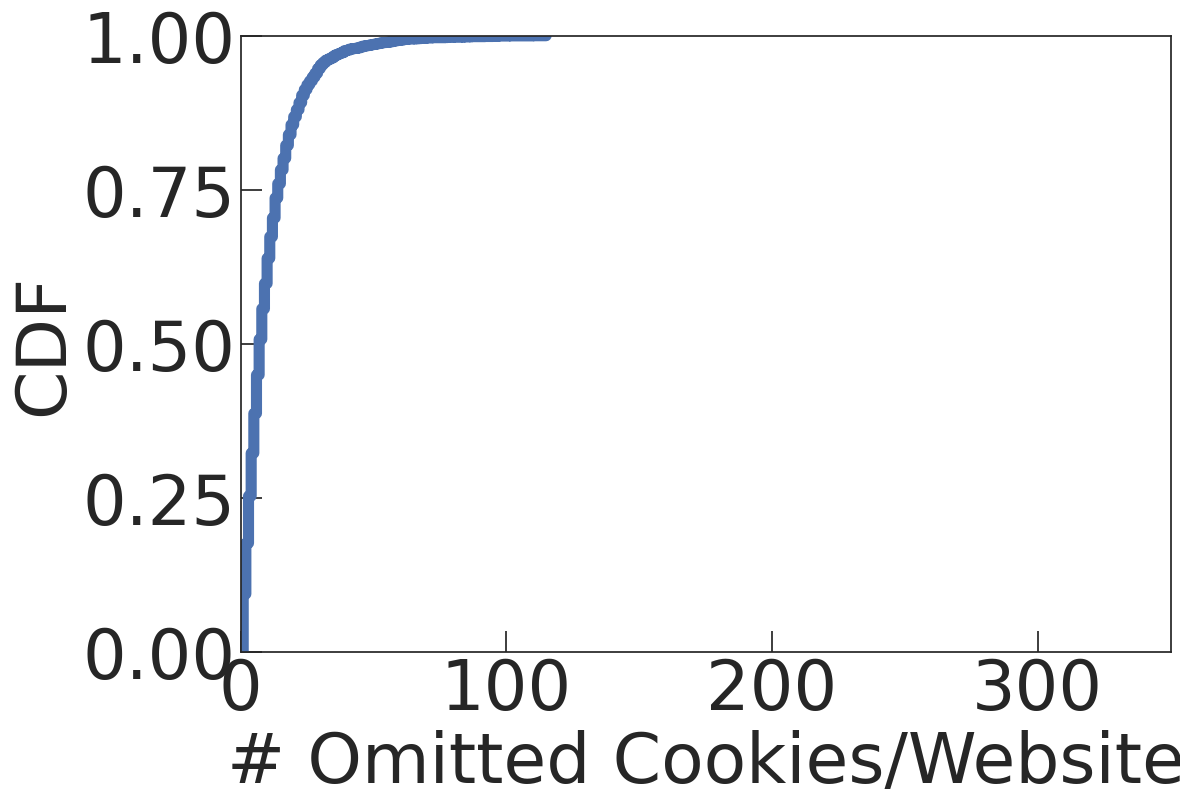

In [35]:
sns.set(rc={'figure.figsize':(12,8),"font.size":35,"axes.titlesize":30,"axes.labelsize":50},style="white", font_scale = 4.5)
sns.set_style("ticks", {"xtick.direction": "in", "ytick.direction": "in"})
plt.rcParams['xtick.major.size'] = 15
plt.rcParams['ytick.major.size'] = 15

ax = sns.ecdfplot(data=omit_counts, x=omit_counts.num_omit_cookies, linewidth=8)
ax.set(xlim=(0, 350))

plt.xlabel('# Omitted Cookies/Website')
plt.ylabel('CDF')
out_file = FIG_DIR / 'eu_omit_cookie_cdf.png'; plt.savefig(out_file, dpi=200, bbox_inches='tight'); print(f"Written to {out_file}")

Written to /home/ducbui/local_projects/consent/paper/sp22/figures/omit_site.pdf


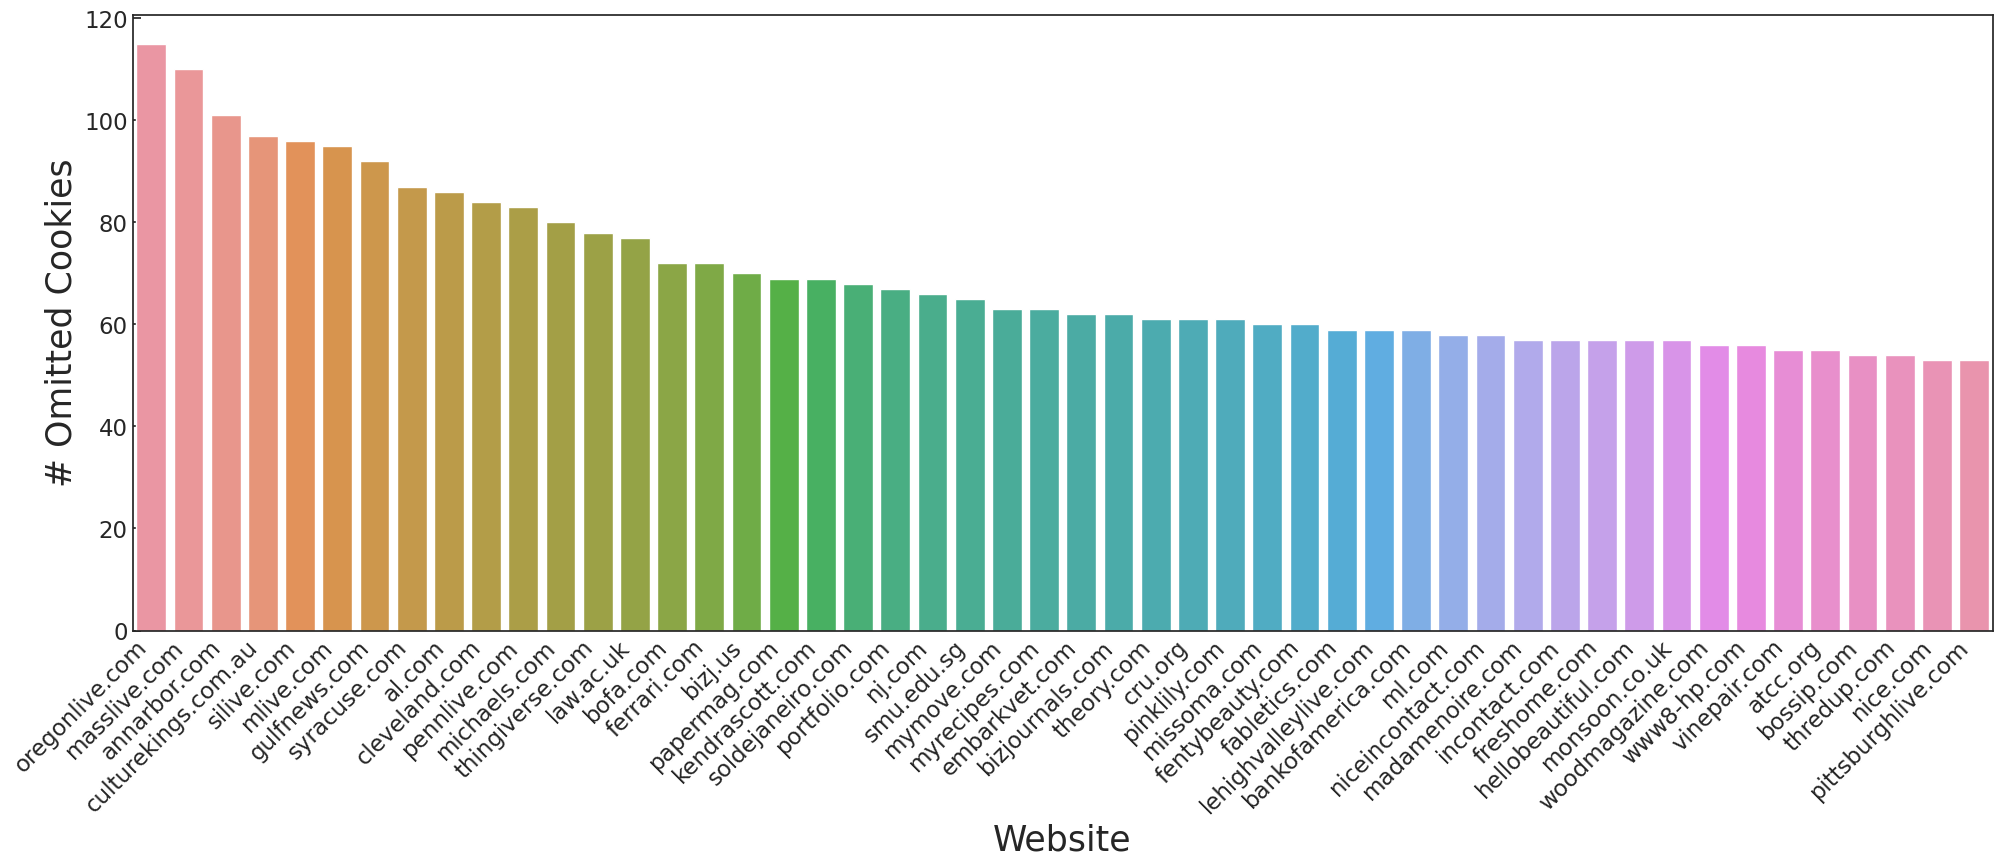

In [36]:
plot_df = omit_counts[:50]

sns.set(rc={'figure.figsize':(24,8),"font.size":35,"axes.titlesize":35,"axes.labelsize":25},style="white", font_scale=1.5)
ax = sns.barplot(x=plot_df.index, y=plot_df.num_omit_cookies)
ticks = plt.xticks(rotation=45, ha='right')

ax.tick_params(left=True, bottom=False, direction="in")
ax.set_ylabel('# Omitted Cookies')
ax.set_xlabel('Website')

out_file = FIG_DIR / 'omit_site.pdf'
plt.savefig(out_file, dpi=200, bbox_inches='tight'); print(f"Written to {out_file}")


## Plot distribution of incorrectly enforced cookies

In [37]:
incor_complies = complies[complies.comply == 'incorrect']
# set(cookielist_sites) - set(omit_complies.site.unique())
incor_counts = incor_complies.site.value_counts().iloc[:50]
incor_counts = incor_counts.to_frame().reset_index().sort_values(by=['site', 'index'], ascending=[False, True])
incor_counts.columns

Index(['index', 'site'], dtype='object')

Written to /home/ducbui/local_projects/consent/paper/sp22/figures/incor_site.pdf


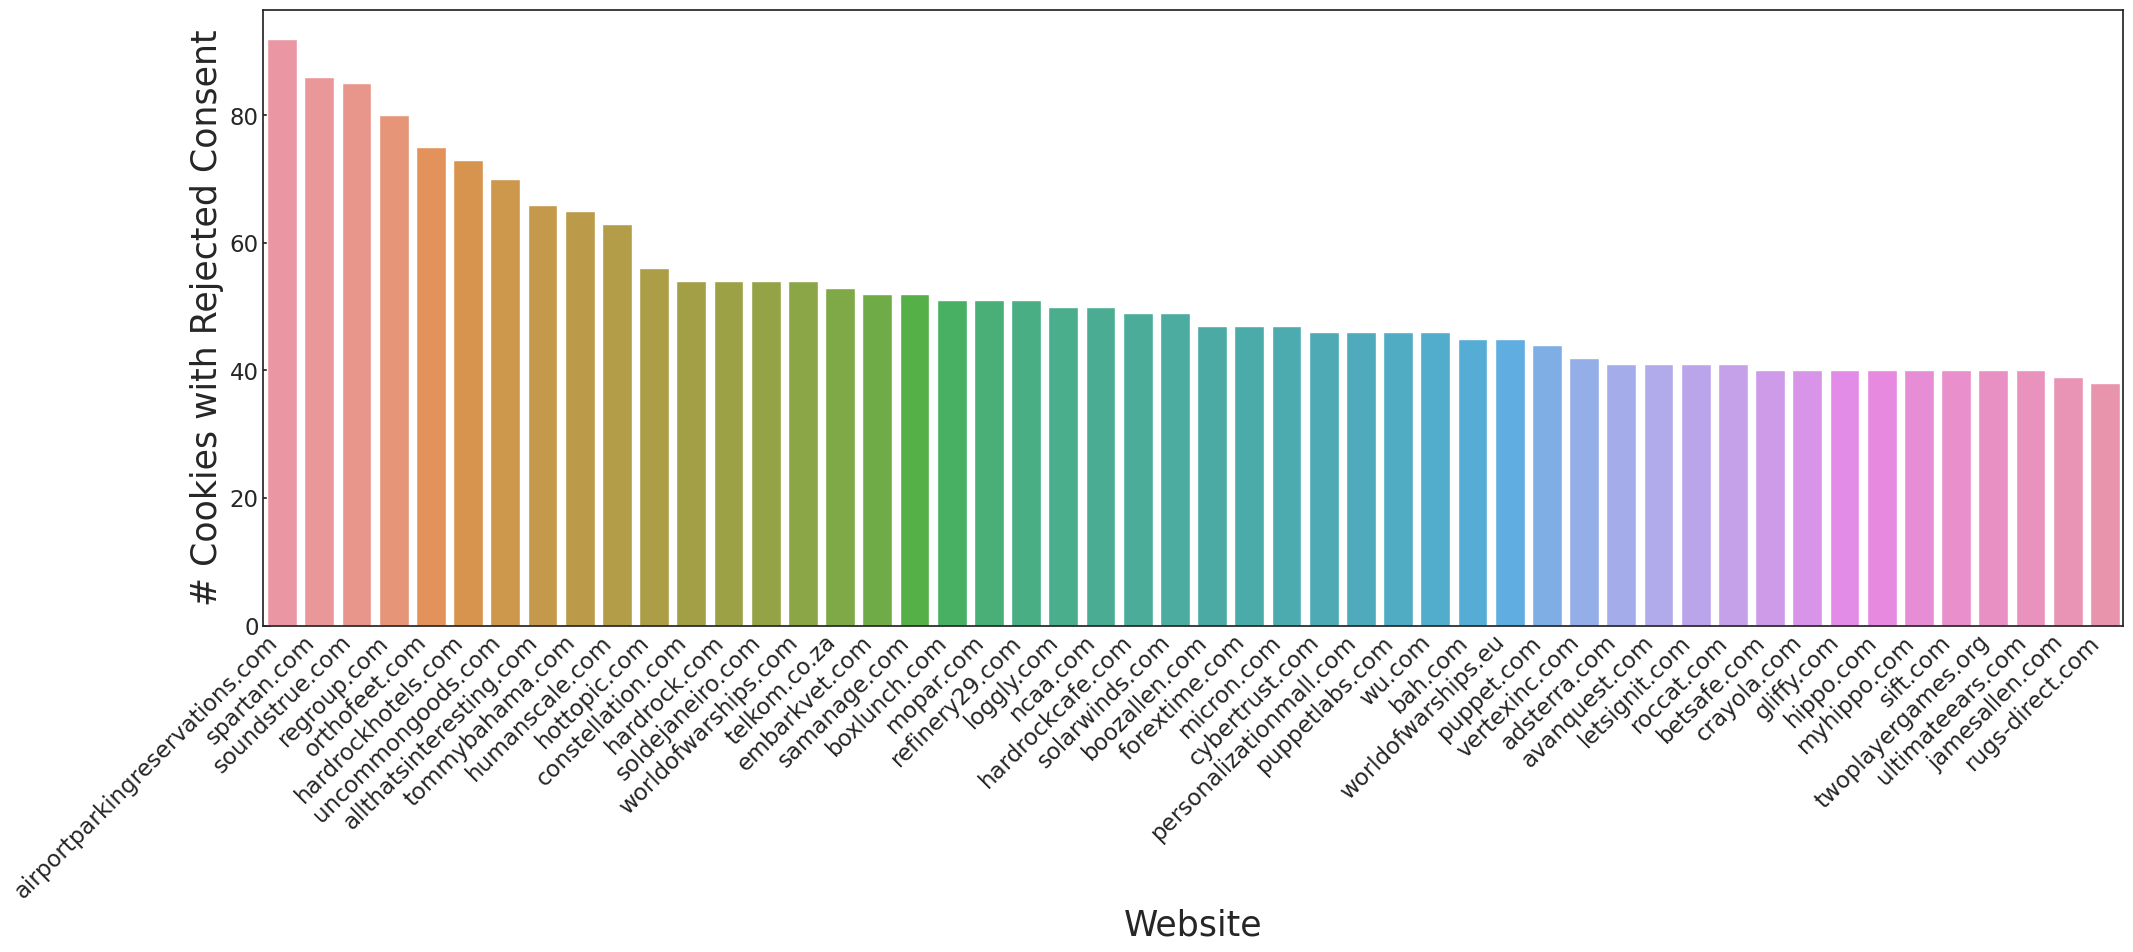

In [38]:
sns.set(rc={'figure.figsize':(24,8),"font.size":35,"axes.titlesize":35,"axes.labelsize":25},style="white", font_scale=1.5)
ax = sns.barplot(x='index', y='site', data=incor_counts)

ticks = plt.xticks(rotation=45, ha='right')

ax.tick_params(left=True, bottom=True, direction="in")
ax.set_ylabel('# Cookies with Rejected Consent')
ax.set_xlabel('Website')

out_file = FIG_DIR / 'incor_site.pdf'
plt.savefig(out_file, dpi=200, bbox_inches='tight'); print(f"Written to {out_file}")